In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings

from matplotlib.ticker import FormatStrFormatter

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

The ***Result.csv*** contains the results of all AI models used in the paper; the dataset contains the following columns:
*   **img_id**: Image IDs for each dataset; some IDs are repeated multiple times since they exist in multiple datasets.

*   **dice_coefficient**: The calculated value for the **Gray-level Dice Coefficient (GDC)** metric.

*   **normalized_mutual_information**: The calculated value for the **Normalized Mutual Information (NMI)** metric.

*   **normalized_root_mse**: The calculated value for the **Normalized Root Mean Square Error (NRMSE)** metric.

*   **dataset**: The datasets that the sample belongs to and the unique values are as follows: [**'KNEE'**, **'SKB'**, **'LUNG'**, **'HEART_LUNGS'**, **'HEART_HEART'**].

*   **algorithm**: The algorithm that produce the result, the unique values are as follows: [**'M2'** -> *'Monte Carlo Dropout 20%'*, **'M4'** -> *'Monte Carlo Dropout 40%'*, **'M6'** -> *'Monte Carlo Dropout 60%'*, **'M8'** -> *'Monte Carlo Dropout 80%'*, **'REG'** -> *'Regression'*, **'M0'** -> *'Ensemble Multiple Annotations'*, **'SINGLE_ANNOTATION'** -> *'Ensemble Single Annotation'*]


In [5]:
df["algorithm"].unique()

array(['M2', 'M4', 'M6', 'M8', 'REG', 'M0', 'SINGLE_ANNOTATION'],
      dtype=object)

In [3]:
df=pd.read_csv('./Result.csv')
df.head()

,img_id,dice_coefficient,normalized_mutual_information,normalized_root_mse,dataset,algorithm
0,0.nii.gz,0.797040,1.225405,0.630886,KNEE,M2
1,1.nii.gz,0.771353,1.185598,0.566479,KNEE,M2
2,2.nii.gz,0.800934,1.203063,0.608442,KNEE,M2
3,3.nii.gz,0.687394,1.125035,0.919048,KNEE,M2
4,4.nii.gz,0.761736,1.168041,0.657594,KNEE,M2


# Box Plot

## Function

In [13]:
DATASET_TITLES={
    "KNEE":"Knee Dataset",
    "SKB":"SIJ Dataset",
    "LUNG":"Lung Dataset",
    "HEART_LUNGS":"Heart Dataset Seg. Lungs",
    "HEART_HEART":"Heart Dataset Seg. Heart",
}
labels=["a","b","c","d","e"]

def outlier_range(df_col,l_param=1.5,u_param=1.5): 
    if l_param==-1 and u_param==-1 :
        return df_col
    else:
        Q1 = df_col.quantile(0.25)
        Q3 = df_col.quantile(0.75)
        IQR = Q3 - Q1     

        filter = (df_col >= Q1 - l_param * IQR) & (df_col <= Q3 + u_param *IQR)
        return  df_col.loc[filter]

def upper_lower_param(TYPE,DATASET,AXS):  
    lower_param=0
    upper_param=0 
    if TYPE=="DC":
        lower_param=1.5  
        upper_param=1.5
        if DATASET=="HEART_LUNGS" or DATASET=="HEART_HEART":
            lower_param=0.5
        elif DATASET=="LUNG":
            lower_param=0 
            AXS.set_ylim(0.75, 1) 
        elif DATASET=="KNEE":
            lower_param=0 
            AXS.set_ylim(0.4, 0.9) 
    elif TYPE=="NMI":
        lower_param=-1  
        upper_param=-1
        if DATASET=="LUNG":
            lower_param=1 
    elif TYPE=="NRMSE":
        lower_param=-1  
        upper_param=-1
        # if DATASET=="HEART_LUNGS" or DATASET=="HEART_HEART":
        #     AXS.set_ylim(0.1, 0.41) 
        if DATASET=="LUNG":
            AXS.set_ylim(0, 0.5) 
        elif DATASET=="SKB":
            AXS.set_ylim(0, 0.5) 
        # elif DATASET=="KNEE":
        #     AXS.set_ylim(0.3, 1.7) 
        
            
            # lower_param=1 

    return lower_param, upper_param
 
def normalize_data(df_sample):
    row_min=df_sample.min()
    row_max=df_sample.max()
    df_sample=df_sample.apply(lambda x: (x-row_min)/(row_max-row_min)) 
    
    return df_sample
       
def draw_box_fig(df,PARAM,type="DC",plot_name="",size=(5,1)):   

    fig, axs = plt.subplots(size[0],size[1],figsize=(4.5,15))
    plt.setp(
        axs, 
        xticklabels=["MA-Ensambles","SA-Ensambles","MCD 20%","MCD 40%","MCD 60%","MCD 80%","Regression"],
    )
    for index_j,dataset in enumerate(df["dataset"].unique()):
        
        sub_df=pd.pivot_table(
            df.loc[(df["dataset"]==dataset)], 
            values=PARAM, index=['img_id'],columns=['algorithm']
        )   
             
        sub_df = sub_df[["M0","SINGLE_ANNOTATION","M2", "M4", "M6", "M8","REG"]] 
        
        lower_param, upper_param =upper_lower_param(type,dataset,axs[index_j])
        
        if type=="NRMSE": 
            axs[index_j].boxplot([outlier_range(normalize_data(sub_df[key].dropna()),lower_param,upper_param) for key in sub_df ])
        else:
            axs[index_j].boxplot([outlier_range(sub_df[key].dropna(),lower_param,upper_param) for key in sub_df ])

                
        axs[index_j].set_title(f' ({labels[index_j]}) {DATASET_TITLES[dataset]}',fontsize=10)
        axs[index_j].tick_params(axis='x', rotation=30,labelsize=8)

    fig.tight_layout()
    plt.savefig(f"Plot/{plot_name}.png")
    plt.show()
    
    

## Dice Coefficient

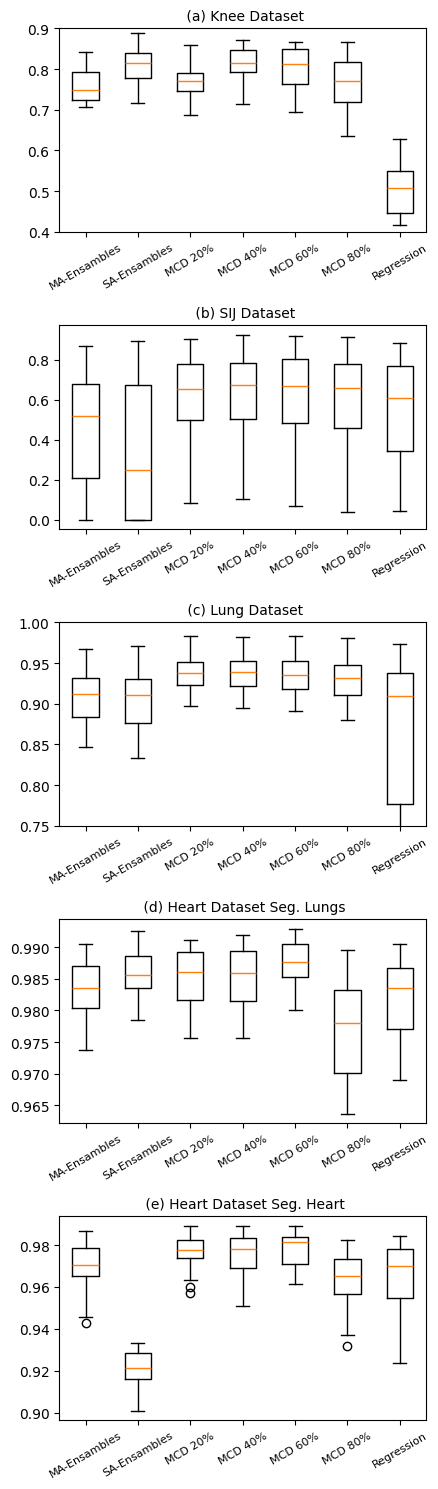

In [14]:
draw_box_fig(df,"dice_coefficient","DC","BoxPlot_GDC_METRIC")

## Normalized Mutual Information

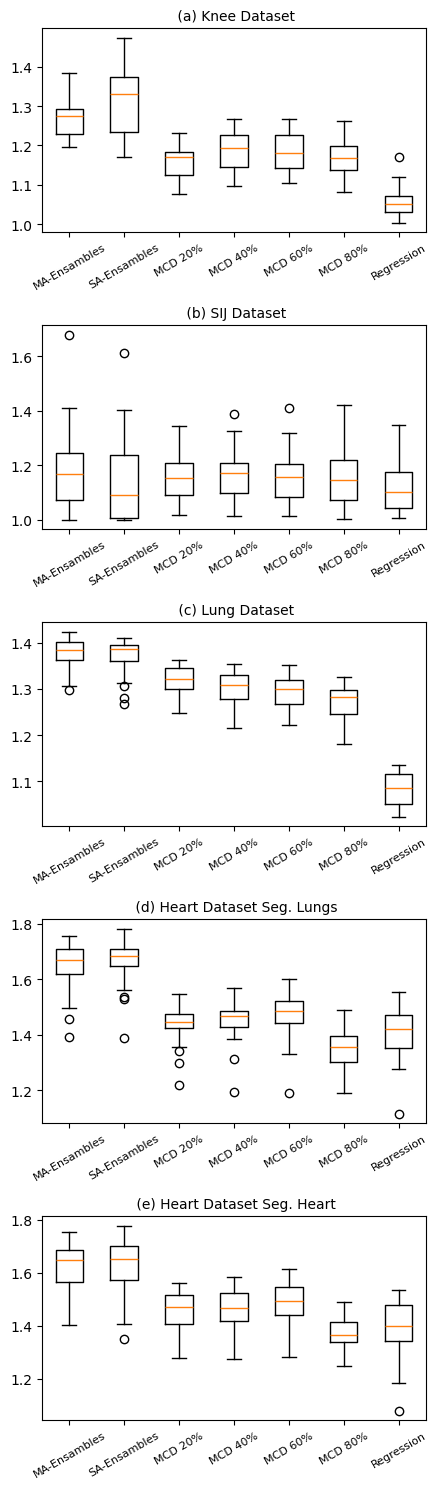

In [15]:
draw_box_fig(df,"normalized_mutual_information","NMI","BoxPlot_NMI_METRIC")

## Normalized Root MSE

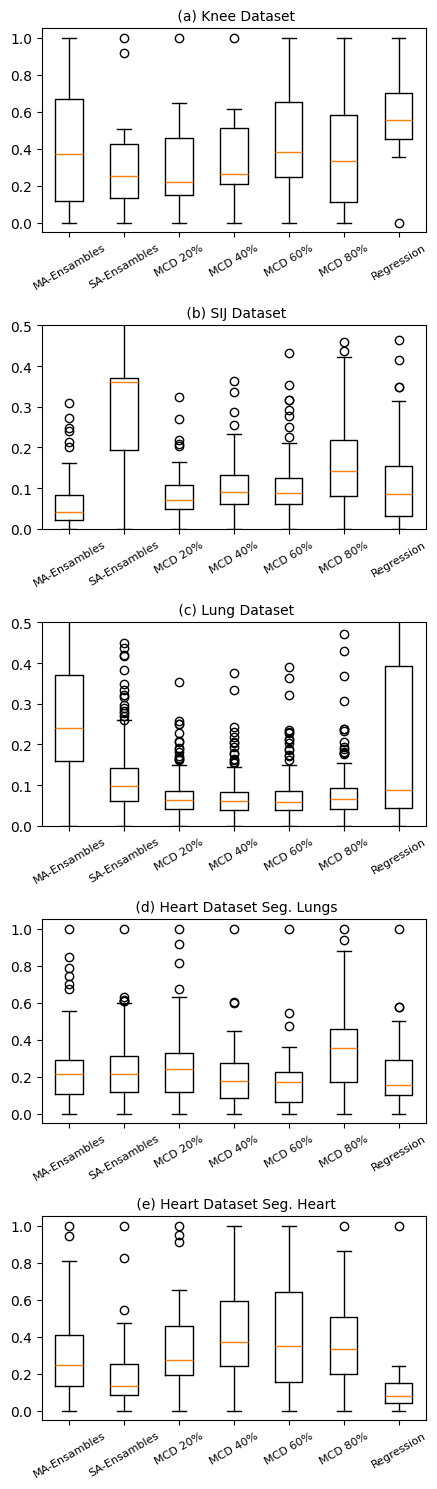

In [16]:
draw_box_fig(df,"normalized_root_mse","NRMSE","BoxPlot_NRMSE_METRIC")

# Bland Altman Plot

## Function

In [18]:
labels= ["SA-Ensambles","MCD 20%","MCD 40%","MCD 60%","MCD 80%","Regression"]
DATASET_TITLES={
    "KNEE":"Knee",
    "SKB":"SIJ",
    "LUNG":"Lung",
    "HEART_LUNGS":"Heart Seg. Lungs",
    "HEART_HEART":"Heart Seg. Heart",
}

def show_bland_fig(df,DATASETS,PARAM,plot_name):   

    fig, axs = plt.subplots(len(DATASETS),6,figsize=(19,15))
    
    for index_i,DATASET in enumerate(DATASETS):

        sub_df=pd.pivot_table(
            df.loc[(df["dataset"]==DATASET)], 
            values=PARAM, index=['img_id'],columns=['algorithm']
        )
                
        data=[
            sub_df["M0"].dropna(),
            sub_df["SINGLE_ANNOTATION"].dropna(),
            sub_df["M2"].dropna(),
            sub_df["M4"].dropna(),
            sub_df["M6"].dropna(),
            sub_df["M8"].dropna() ,
            sub_df["REG"].dropna()
        ]
        
        row=data[0].reset_index(drop=True)
        if PARAM=="normalized_root_mse":
            row_min=row.min()
            row_max=row.max()
            row=row.apply(lambda x: (x-row_min)/(row_max-row_min)) 

        for index_j,col in enumerate(data[1:]): 
            
            col=col.reset_index(drop=True)
            if PARAM=="normalized_root_mse":
                col_min=col.min()
                col_max=col.max()
                col=col.apply(lambda x: (x-col_min)/(col_max-col_min))
            
            sm.graphics.mean_diff_plot(row,col,ax = axs[index_i][index_j],scatter_kwds={
                # 'color': "#91cfec"
            })   
            
            mean_diff_text = float(axs[index_i][index_j].texts[0].get_text().split(":")[1])
            axs[index_i][index_j].texts[0].set_text(f"md: {'{:.2f}'.format(mean_diff_text)}")
            
            axs[index_i][index_j].texts[0].set_va('bottom') 
            X,Y=axs[index_i][index_j].texts[0].get_position()
            
            
            #For MSE we do not need below line, for other metric we need them
            if PARAM=="normalized_root_mse":
                pass
            elif float(axs[index_i][index_j].texts[0].get_text().split(" ")[1])>0:
                axs[index_i][index_j].texts[0].set_position((X-0.67, Y))
            else:   
                axs[index_i][index_j].texts[0].set_position((X-0.63, Y))
            axs[index_i][index_j].texts[0].set_fontsize(12)
            
            
            axs[index_i][index_j].texts[1].set_va('top') 
            X,Y=axs[index_i][index_j].texts[1].get_position()
            axs[index_i][index_j].texts[1].set_position((X-0.5, Y)) 
            axs[index_i][index_j].texts[1].set_fontsize(10)
            
            
            X,Y=axs[index_i][index_j].texts[2].get_position()
            axs[index_i][index_j].texts[2].set_position((X-0.5, Y)) 
            axs[index_i][index_j].texts[2].set_fontsize(10)            

            
            axs[index_i][index_j].set_xlabel("MA-Ensambles",fontsize=8,labelpad=1)
            axs[index_i][index_j].set_ylabel(labels[index_j],fontsize=9)    
            if index_j==5:   
                axs[index_i][index_j].text(
                    1.02,(0.25 if index_i>2 else 0.45), DATASET_TITLES[DATASET], fontsize=12,rotation=90,
                    transform=axs[index_i][index_j].transAxes
                ) 
            axs[index_i][index_j].tick_params(axis='both', which='both', labelsize=8)
                
            axs[index_i][index_j].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    fig.subplots_adjust(wspace=0.25, hspace=0.15)
    plt.savefig(f"Plot/{plot_name}.png")
    plt.show()

## Dice Coefficient

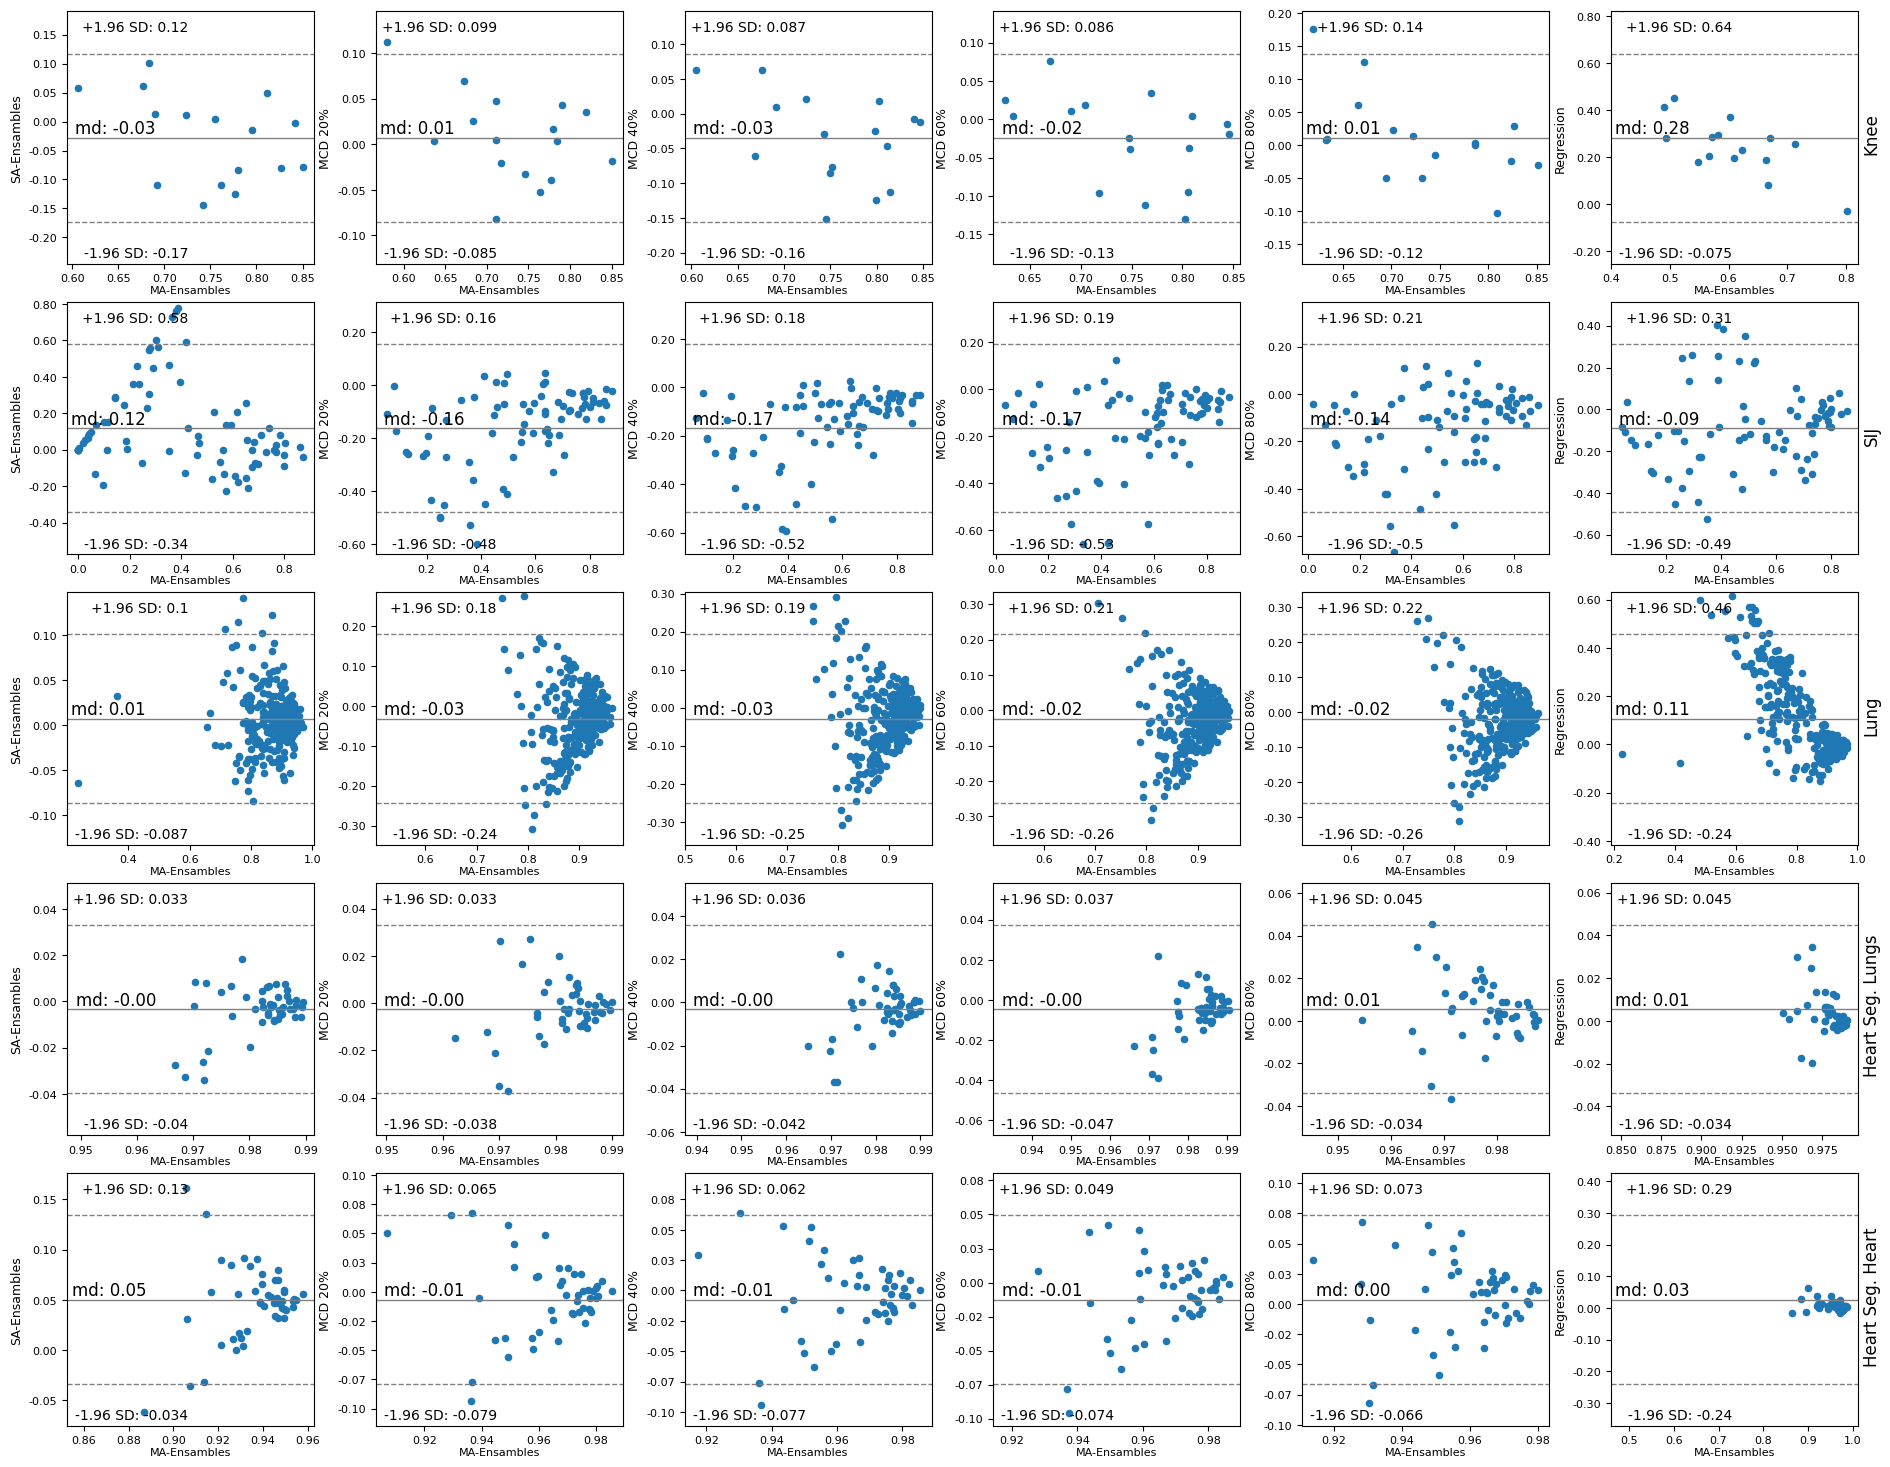

In [19]:
show_bland_fig(df,df["dataset"].unique(),"dice_coefficient","BlandAltmanPlot_GDC_METRIC")

## Normalized Mutual Information

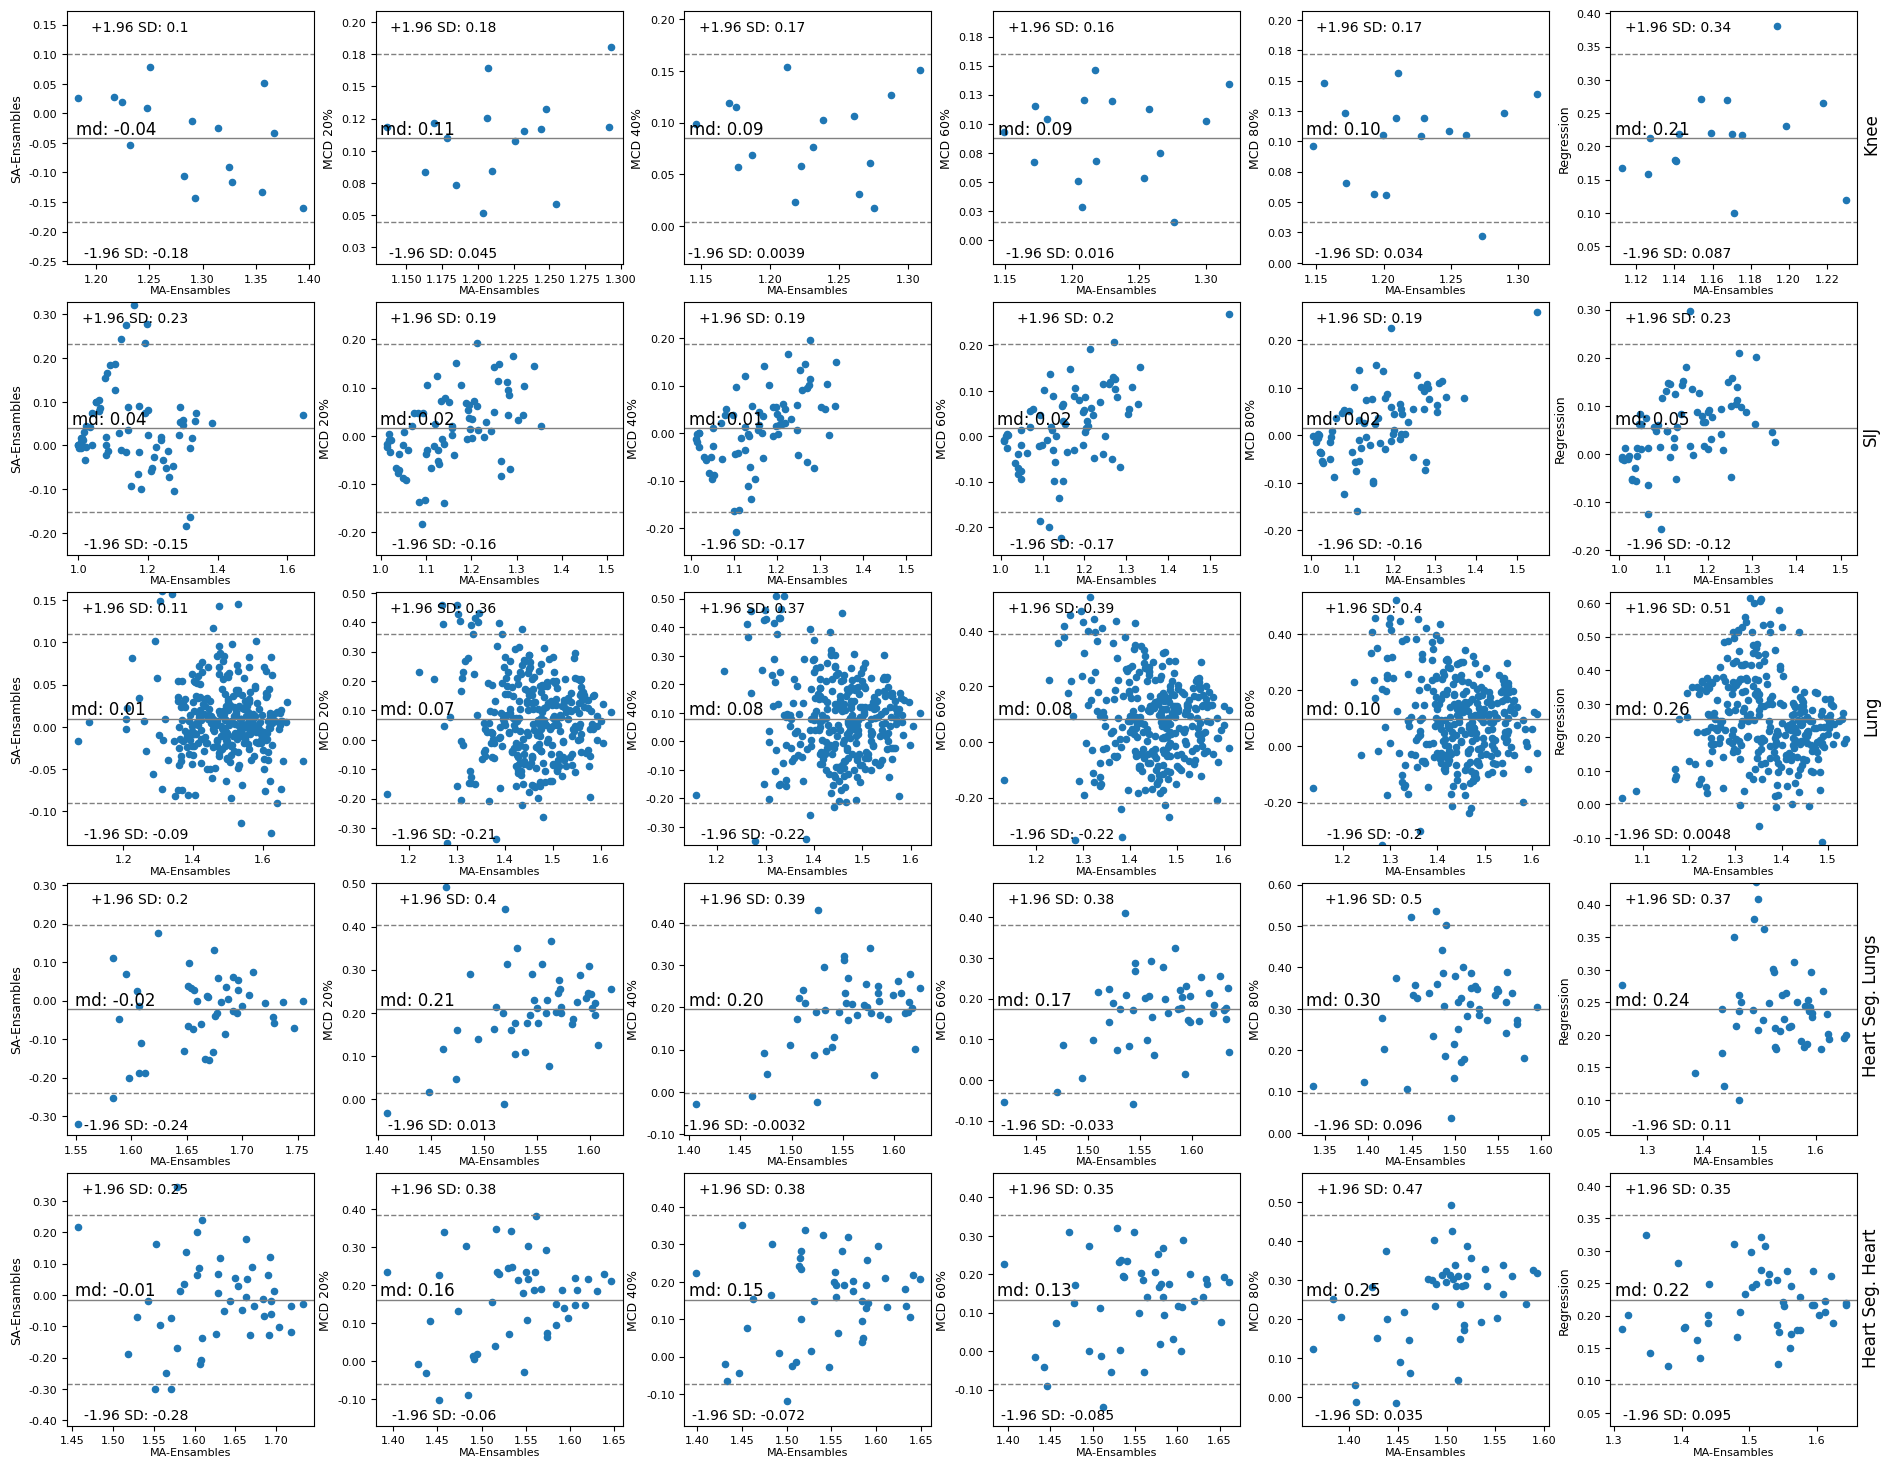

In [20]:
show_bland_fig(df,df["dataset"].unique(),"normalized_mutual_information","BlandAltmanPlot_NMI_METRIC")

## Normalized Root MSE

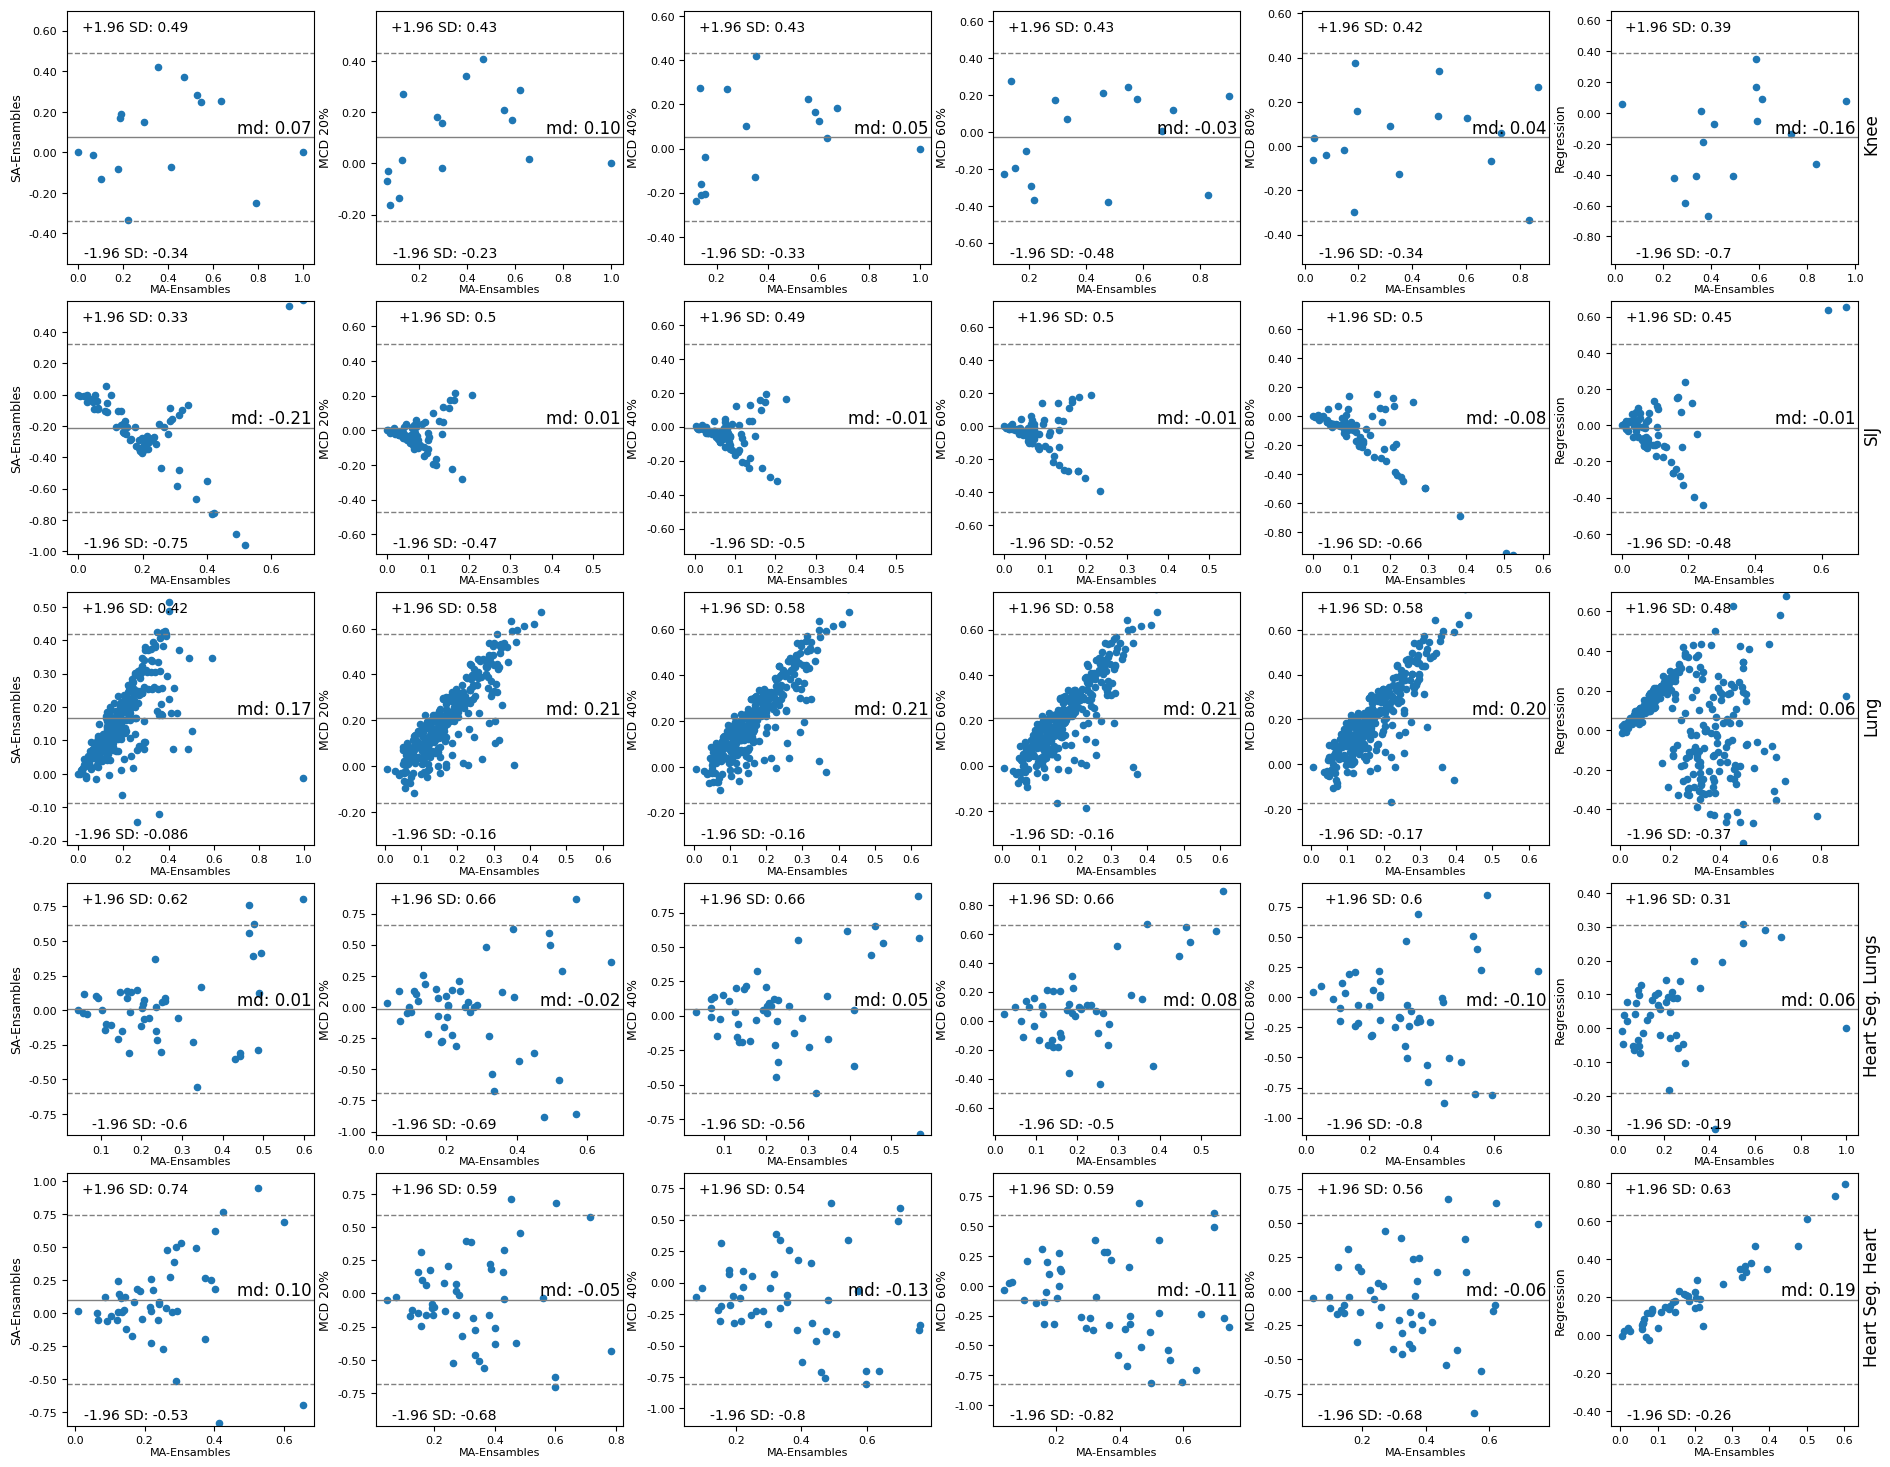

In [21]:
show_bland_fig(df,df["dataset"].unique(),"normalized_root_mse","BlandAltmanPlot_NRMSE_METRIC")

# Draw Line Model

## Function

In [22]:
labels= ["SA-Ensambles","MCD 20%","MCD 40%","MCD 60%","MCD 80%","Regression"]
DATASET_TITLES={
    "KNEE":"Knee",
    "SKB":"SIJ",
    "LUNG":"Lung",
    "HEART_LUNGS":"Heart Seg. Lungs",
    "HEART_HEART":"Heart Seg. Heart",
}

def draw_line_fig(df,DATASETS,PARAM,plot_name):   

    fig, axs = plt.subplots(len(DATASETS),6,figsize=(19,15))
         
    for index_i,DATASET in enumerate(DATASETS):

        sub_df=pd.pivot_table(
            df.loc[(df["dataset"]==DATASET)], 
            values=PARAM, index=['img_id'],columns=['algorithm']
        )
                
        data=[
            sub_df["M0"].dropna(),
            sub_df["SINGLE_ANNOTATION"].dropna(),
            sub_df["M2"].dropna(),
            sub_df["M4"].dropna(),
            sub_df["M6"].dropna(),
            sub_df["M8"].dropna() ,
            sub_df["REG"].dropna()
        ]
        
        row=data[0].reset_index(drop=True)
        if PARAM=="normalized_root_mse":
            row_min=row.min()
            row_max=row.max()
            row=row.apply(lambda x: (x-row_min)/(row_max-row_min)) 
        row=np.array(row).reshape(-1, 1)

        for index_j,col in enumerate(data[1:]): 

            col=col.reset_index(drop=True)
            if PARAM=="normalized_root_mse":
                col_min=col.min()
                col_max=col.max()
                col=col.apply(lambda x: (x-col_min)/(col_max-col_min))
            
            model = LinearRegression().fit(row, col)                

            axs[index_i, index_j].scatter(row, col,color='#4379a0',s=9)
            axs[index_i, index_j].plot(row, model.predict(row),color='k',linewidth=1)
               
            axs[index_i][index_j].set_xlabel("MA-Ensambles",fontsize=8,labelpad=1)
            axs[index_i][index_j].set_ylabel(labels[index_j],fontsize=9)    
            
            if index_j==5:   
                axs[index_i][index_j].text(
                    1.02,(0.15 if index_i>2 else 0.4), DATASET_TITLES[DATASET], fontsize=12,rotation=90,
                    transform=axs[index_i][index_j].transAxes
                )
                
            axs[index_i][index_j].tick_params(axis='both', which='both', labelsize=8) 
            

    fig.subplots_adjust(wspace=0.3, hspace=0.25)
    plt.savefig(f"Plot/{plot_name}.png")
    plt.show()

## Dice Coefficient

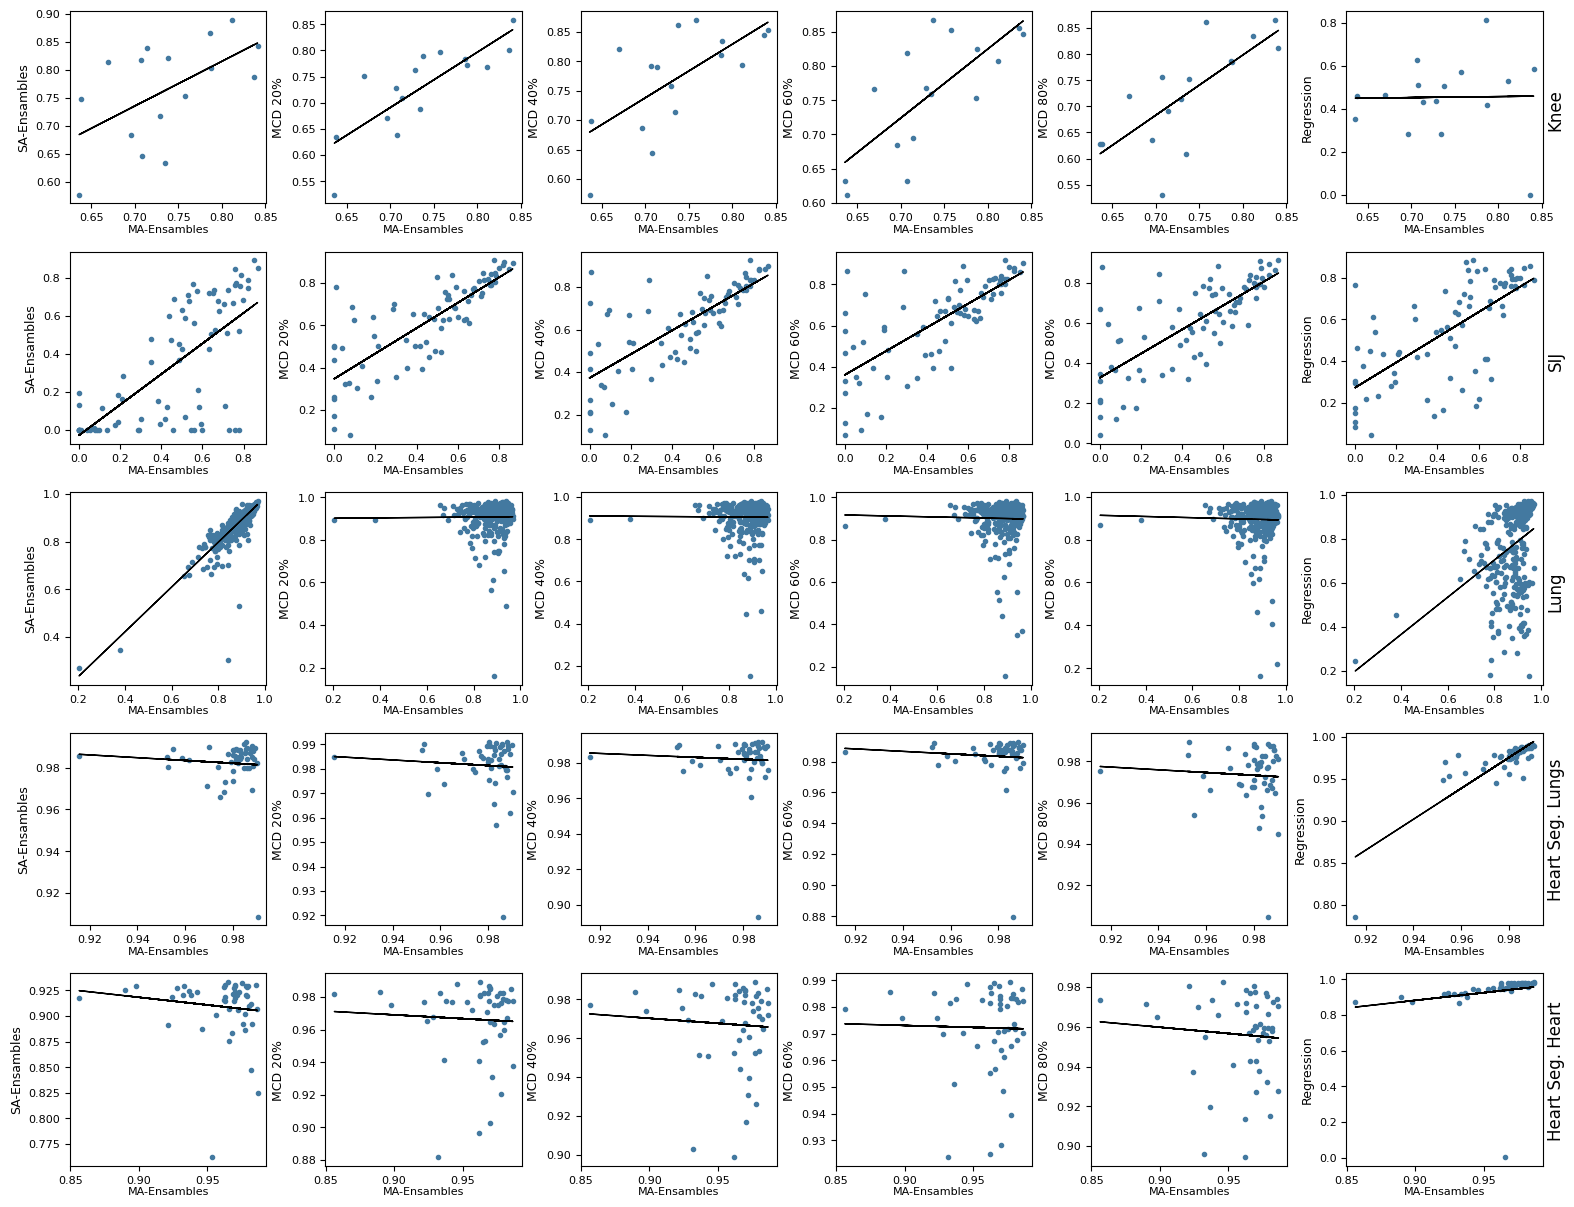

In [23]:
draw_line_fig(df,df["dataset"].unique(),"dice_coefficient","DrawLinePlot_GDC_METRIC")

## Normalized Mutual Information

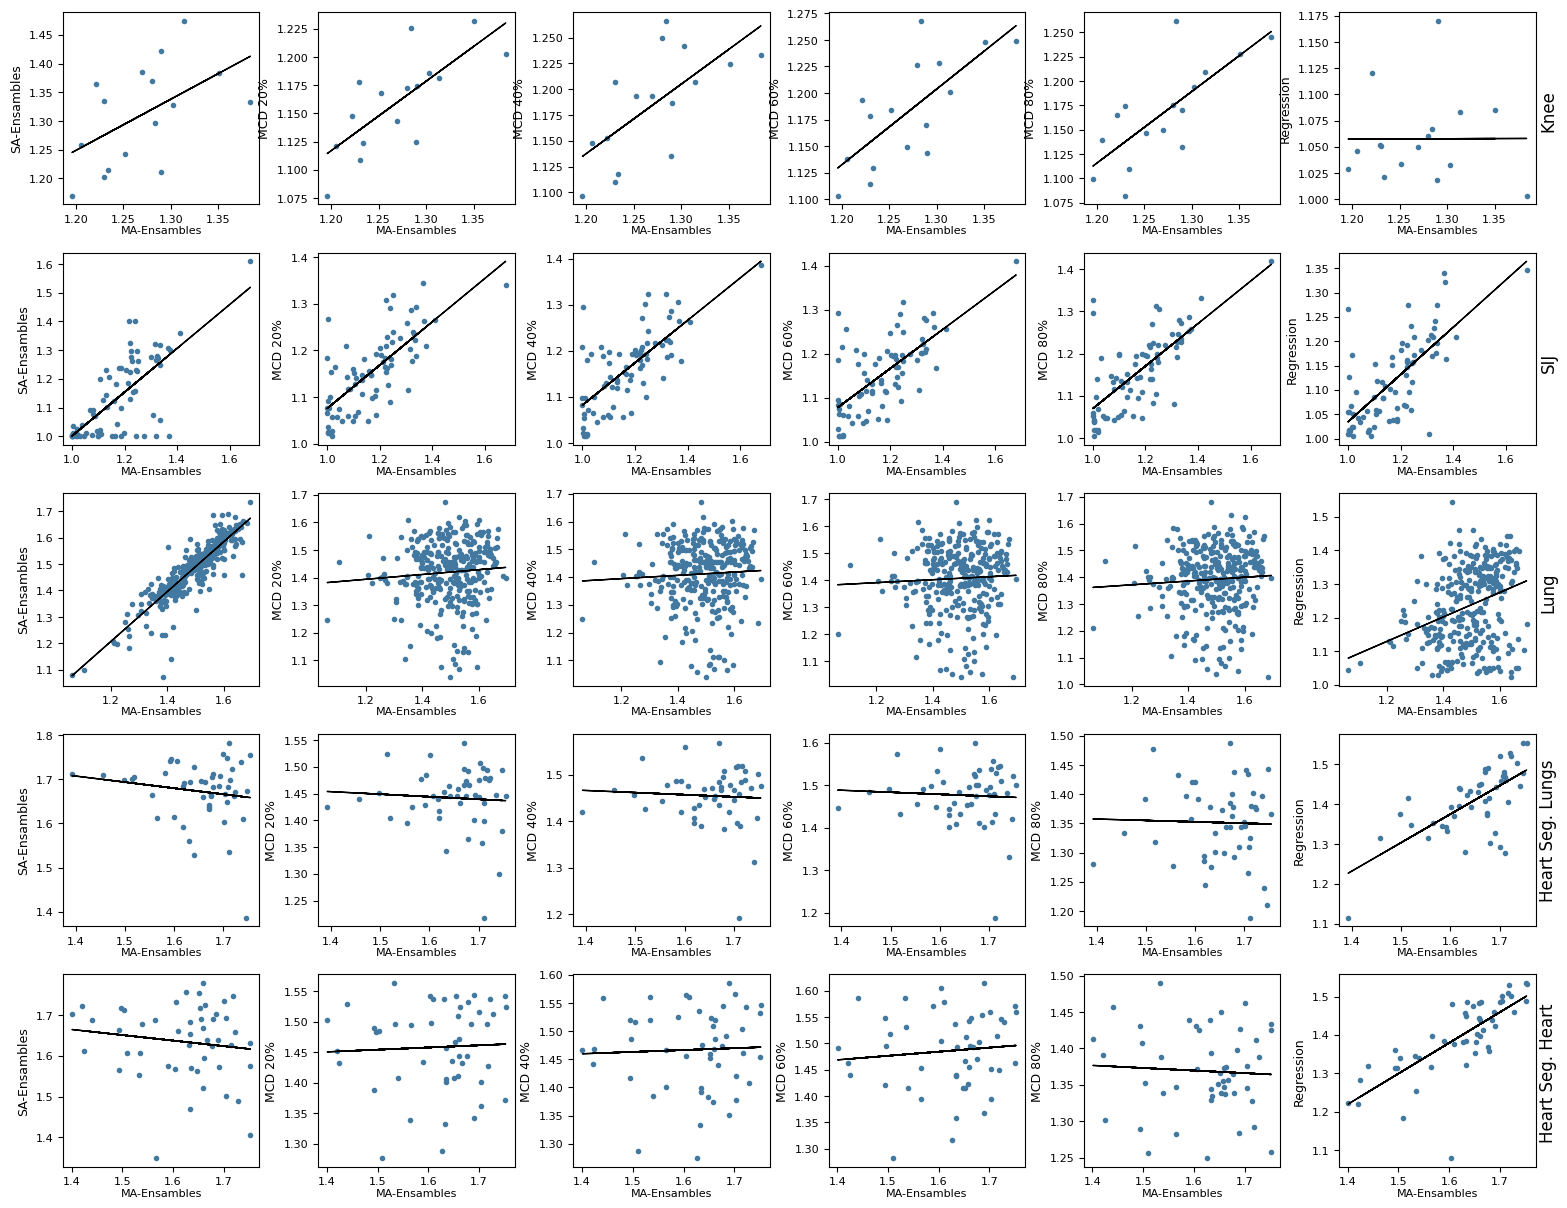

In [24]:
draw_line_fig(df,df["dataset"].unique(),"normalized_mutual_information","DrawLinePlot_NMI_METRIC")

## Normalized Root MSE

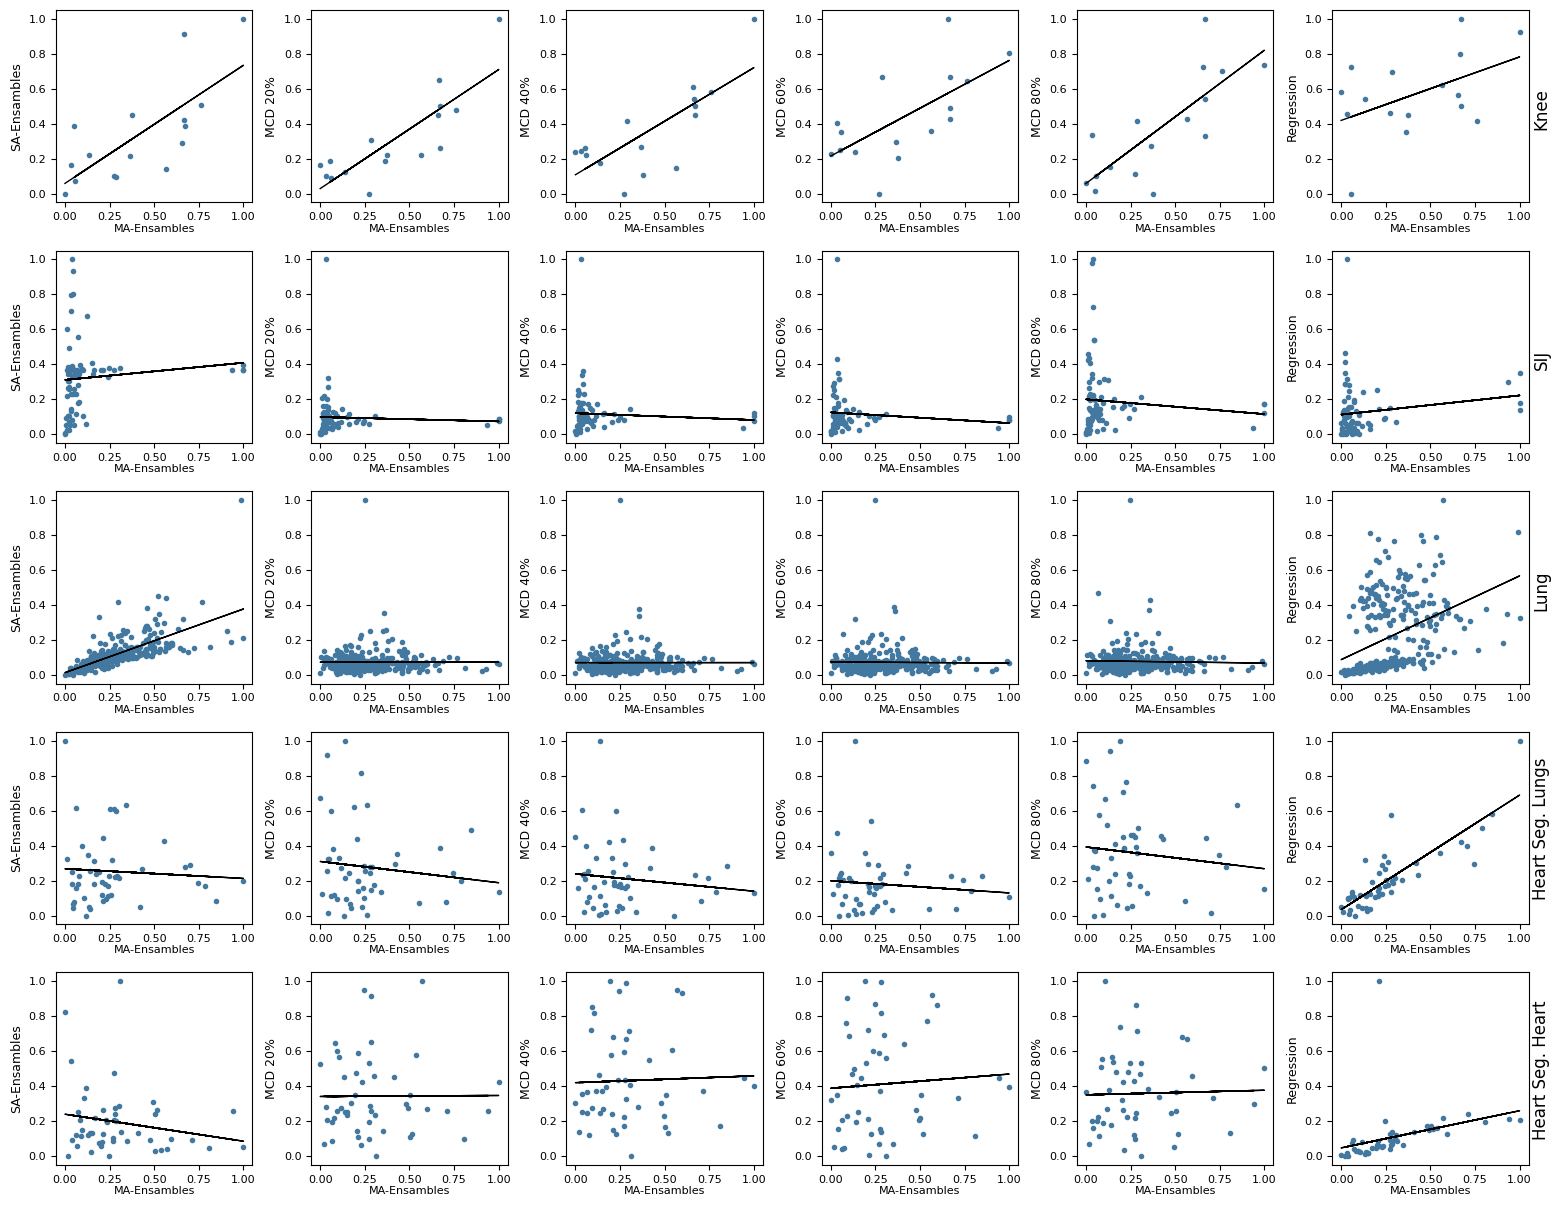

In [25]:
draw_line_fig(df,df["dataset"].unique(),"normalized_root_mse","DrawLinePlot_NRMSE_METRIC")